In [11]:
import numpy as np
import pandas as pd
import os
import sys
import importlib
import glob


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import ExperimentClass
import tools
import math_functions as mf

class PSI_EkClass(ExperimentClass.Experiment):
    
    def __init__(self, name, intensity_list,  t_F0 = [0, 15], t_Fstat = [22, 35], t_Fmax = [35.004, 35.007]):
        super().__init__(name, "PSI", DataType = ".csv", sep = ';')
        self.intensity_list = intensity_list
        
        F_max = []
        F_stat = []
        F_0 = []
        phi_stat = []
        phi_0 = []
        NPQ = []
        ETR = []

        for i, k in enumerate(self.records[::-1]):
            F_max.append(np.mean(self.Data[k][np.where(self.Time>= t_Fmax[0])[0][0] :np.where(self.Time>= t_Fmax[1])[0][0]]))
            F_0.append(np.mean(self.Data[k][np.where(self.Time>= t_F0[0])[0][0] :np.where(self.Time>= t_F0[1])[0][0]]))
            F_stat.append(np.mean(self.Data[k][np.where(self.Time>= t_Fstat[0])[0][0] :np.where(self.Time>= t_Fstat[1])[0][0]]))
            phi_stat.append((F_max[i] - F_stat[i]) / F_max[i])
            phi_0.append((F_max[i] - F_0[i]) / F_max[i])
            NPQ.append((F_max[0] - F_max[i])/F_max[i])
            ETR.append(phi_stat[i] * self.intensity_list[i])
            
        self.Fm_norm = F_max[0]
        
        F_max = list(np.array(F_max)/self.Fm_norm)
        F_stat = list(np.array(F_stat)/self.Fm_norm)
        F_0 = list(np.array(F_0)/self.Fm_norm)
        
        self.params = pd.DataFrame({'Record': self.records[::-1], 'Actinic': self.intensity_list, 'F_max': F_max, 'F_stat': F_stat, 'F_0': F_0, 'phi_stat': phi_stat, 'phi_0': phi_0, 'NPQ': NPQ, 'ETR': ETR})
        
        self.light = [0] + self.params.Actinic.tolist()
        self.ETR = [0] + self.params.ETR.tolist()
        
        self.popt, self.pcov, self.xfit, self.yfit = tools.Ek_fit(self.light, self.ETR, 0, 100, 100, p0 = [200, 200])

        self.fit_err = tools.my_err(self.xfit, self.popt, self.pcov, mf.Ek)
        
        self.Ek = self.popt[1]
        self.Ek_err =  np.sqrt(np.diag(self.pcov))[1]
        
        
        

In [148]:
import numpy as np
import pandas as pd
import os
import sys
import re
import importlib
import glob
from scipy.signal import find_peaks
from scipy.signal import windows as wd


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import EkClass_PSI
import tools
import math_functions as mf
from ExperimentClass import Experiment

class BodeClass_PSI_new(Experiment):
    def __init__(self, name, bode_records = None, frequency_list = None, index_start = 0, time_start = None, median_filtering_windos_size = 1, 
                 windowing = None, padding = False, padding_value = None, pic_search_window = 2, nuber_of_harmonics = 3):
        super().__init__(name, "PSI", DataType = ".csv", sep = ';')
        
        self.date = re.findall(r'\d+', name)
        self.Ek_name = f"{self.date[0]}_activation"
        
        self.Ek_experiment = EkClass_PSI.EkClass_PSI(self.Ek_name, [0, 10, 20, 30, 40, 60, 90])
        
        if bode_records is None:
            self.bode_records = ["P0.0078125s", "P0.015625s", "P0.03125s", "P0.0625s", "P0.125s", "P0.25s", "P0.5s", "P1s_5", "P2s", "P4s", "P8s", "P16s", "P32s", "P64s", "P128s"]
        else:           
            self.bode_records = bode_records
        
        if frequency_list is None:
            self.frequency_list = [0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128][::-1]
        else:
            self.frequency_list = frequency_list
        self.median_filtering_windos_size = median_filtering_windos_size
        self.windowing = windowing
        self.padding = padding
        self.padding_value = padding_value
        self.pic_search_window = pic_search_window
        self.Fm_calib = self.Ek_experiment.Fm_norm
        
        if time_start is None:
            self.index_start = index_start
        else:
            self.index_start = np.where(self.Time > time_start)[0][0]
        
        self.bode_times = []
        self.bode_data = []

        for i in self.bode_records:
            index = self.records.index(i)
            self.bode_times.append(self.clean_times[index][self.index_start:])
            self.bode_data.append(tools.median_filter(self.clean_data[index][self.index_start:],self.median_filtering_windos_size)/self.Fm_calib)
           
        self.signal = []
        
        harmonics = pd.DataFrame()

        for i, k in enumerate(self.bode_records):
            if self.windowing is None: 
                self.signal.append(self.bode_data[i])
            elif self.windowing == "flat-top":
                self.signal.append(self.bode_data[i] * wd.flattop(len(self.bode_data[i])))
                
            harmonics = pd.concat([harmonics, self.get_harmonics(self.frequency_list[i], self.bode_times[i], self.signal[i], nuber_of_harmonics, self.padding, self.padding_value)])
            
        self.harmonics = harmonics
        
    def get_harmonics(self, input_freq, time, signal, nb_of_harmonics, padding, padding_value):
        F, A, P = tools.FFT(time, signal, padding, padding_value)
        index_fund = tools.closest_index(F, input_freq)
        harmonics = {'f_input': input_freq}
        for i in range(nb_of_harmonics):
            harmonics[f'f_{i}'] = F[index_fund*(i+1)]
            harmonics[f'A_{i}'] = A[index_fund*(i+1)]
            harmonics[f'P_{i}'] = P[index_fund*(i+1)]

        return pd.DataFrame(harmonics, index=[0])

In [149]:
names = ["20230829_bode","20230830_bode","20230901_bode"]
tests =[]
for name in names:
    tests.append(BodeClass_PSI_new(name, time_start= 30, windowing="flat-top", pic_search_window= 5))

In [155]:
importlib.reload(tools)
test = BodeClass_PSI_new("20230830_bode", time_start= 30, windowing="flat-top", pic_search_window= 5)

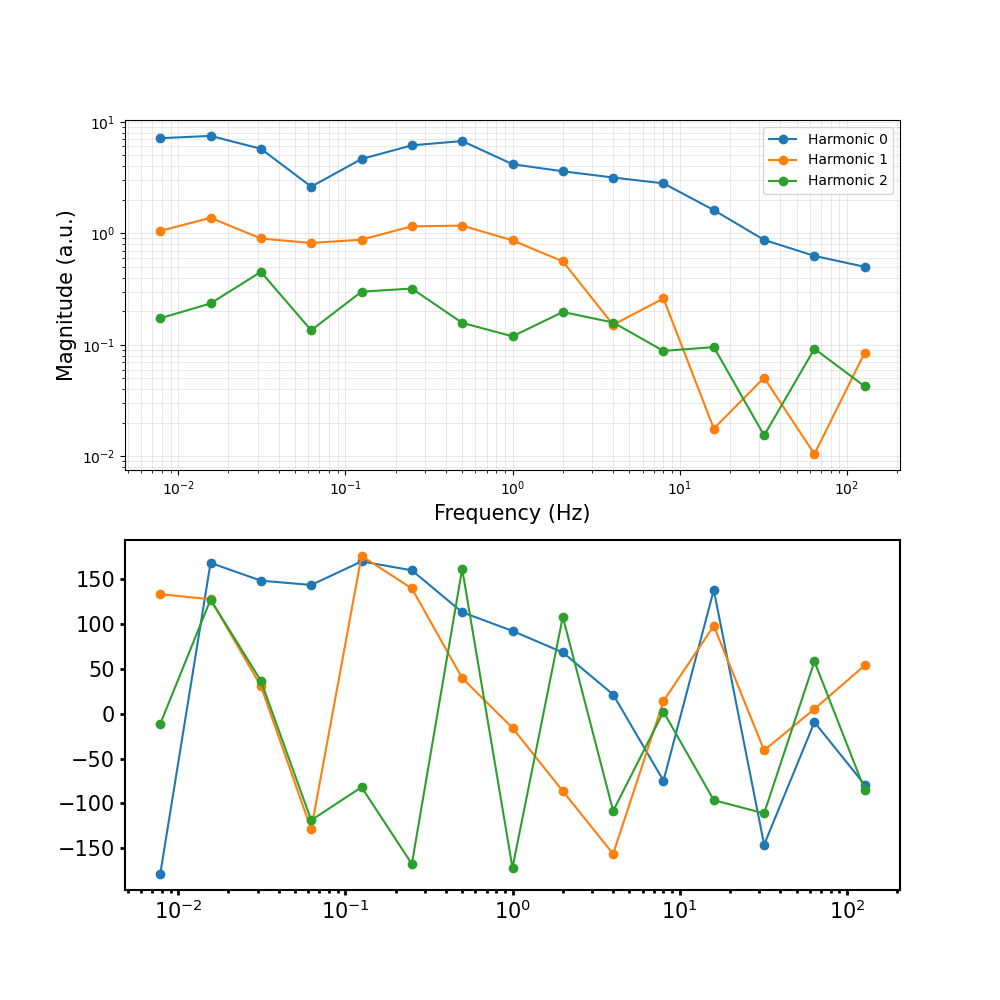

In [165]:
import matplotlib.pyplot as plt
%matplotlib widget
fig, ax  =  plt.subplots(2,1, figsize = (10,10))
for i in range(3):
    ax[0].plot(test.harmonics.f_input, test.harmonics[f'A_{i}'], 'o-', label = f'Harmonic {i}')
    ax[1].plot(test.harmonics.f_input, test.harmonics[f'P_{i}'], 'o-', label = f'Harmonic {i}')
ax[0] = tools.bode_plot_axes(ax[0])
#ax[0].set_yscale('linear')
#ax[0].set_xscale('log')
ax[1].set_xscale('log')

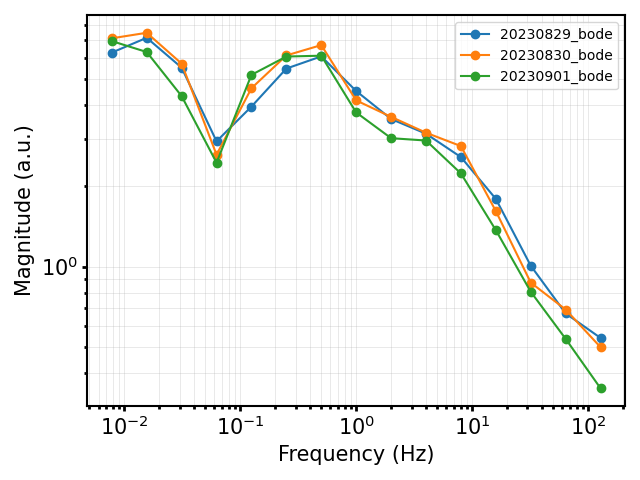

In [68]:
import matplotlib.pyplot as plt
%matplotlib widget
fig, ax = plt.subplots()
for test in tests:
    ax.plot(test.frequency_list, test.fund_amp, 'o-', label = test.name)
ax = tools.bode_plot_axes(ax)
fig.tight_layout()

In [134]:
importlib.reload(tools)

def merge_dict(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = [value, dict_1[key]]
    return dict_3

a0 = pd.DataFrame()
a = pd.DataFrame({'a' : [1], 'b' : [2], 'c' : [3]})
b = pd.DataFrame({'a' : [4], 'b' : [5], 'c' : [6]})
c = pd.DataFrame({'a' : [7], 'b' : [8], 'c' : [9]})

init = pd.concat([a0, a])
init = pd.concat([init, b])
#init = merge_dict(init, c)

init



,a,b,c
0,1,2,3
0,4,5,6


In [119]:
c = 
c

{'a': [4, [1]], 'b': [5, [2]], 'c': [6, [3]]}